In [3]:
from kmer_counting import sequence2matrix
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
import copy
from typing import List
import tqdm
from sklearn.model_selection import train_test_split
import imblearn

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torcheval.metrics import MulticlassAccuracy

from torchinfo import summary

### Collect and Select Data

In [2]:
circ_rna_path = "dataset/human_sequence_v3.0"
file = open(circ_rna_path).readlines()
data = []
for lines in file:
    lines = lines.replace("\n","").split(" ")
    lines[0] = lines[0].split("_")
    lines[0][0] = lines[0][0].split("-", 1)
    data.append({
        "species":lines[0][0][0],
        "type": lines[0][0][1],
        "id": lines[0][1],
        "strand": lines[1]
    })
len(data)

768986

In [3]:
df = pd.DataFrame(data)
df.drop_duplicates(subset="strand", keep=False, inplace=True)
df = df[df["strand"] != "unknown"]
df.head()

,species,type,id,strand
1,hsa,RP11-206L10,0001,TATCTTAAATAGTGAAGATGGAGAAATAGTCAATAATGAAGAGCAT...
2,hsa,RP11-206L10,0002,TATCTTAAATAGTGAAGATGGAGAAATAGTCAATAATGAAGAGCAT...
3,hsa,SAMD11,0013,GTGCGGCTGTGTCCCCTTCCCCTGCCCAACATGCTGTATGTCTGAG...
4,hsa,SAMD11,0001,CCAGGACGGCAACCTTCCCACCCTCATATCCAGCGTCCACCGCAGC...
5,hsa,NOC2L,0001,CCGGCGTAAAGGCCGTGCCTCTGAGCACAAAGACCAGCTCTCTCGG...


In [4]:
df.describe()

,species,type,id,strand
count,564783,564783,564783,564783
unique,1,24318,25930,564783
top,hsa,intergenic,0001,TATCTTAAATAGTGAAGATGGAGAAATAGTCAATAATGAAGAGCAT...
freq,564783,23684,21499,1


In [5]:
li, cnt = np.unique(df["type"], return_counts=True)
dicts = [[i,j] for i, j in zip(li,cnt)]
len(li)

24318

In [6]:
# take 8 of the most frequent type
total_rna_type = 8
rna_types = np.array(sorted(dicts, key=lambda x:x[1])[::-1][:total_rna_type])[:,0]
rna_types

array(['intergenic', 'TTN', 'RYR2', 'MALAT1', 'USP34', 'MACF1', 'SNHG14',
       'BIRC6'], dtype='<U21')

In [7]:
df = df[df["type"].isin(rna_types) ]
df.shape

(28946, 4)

### Convert to vector (strand) and integer (label)

In [8]:
X = df["strand"].to_numpy()
y = df["type"]
X.shape, y.shape

((28946,), (28946,))

In [9]:
converter = sequence2matrix()
matrix = converter.fit(X, save_dir="dataset/multiclass_data")

In [10]:
np.unique(y)

array(['BIRC6', 'MACF1', 'MALAT1', 'RYR2', 'SNHG14', 'TTN', 'USP34',
       'intergenic'], dtype=object)

In [13]:
#label_converter = {'AHNAK':0, 'BIRC6':1, 'DST':2, 'HERC1':3, 'MACF1':4, 'MALAT1':5, 'PTK2':6,'PTPRD':7, 'RYR2':8, 'SNHG14':9, 'SNHG23':10, 'SYNE1':11, 'TTN':12, 'USP34':13,'VPS13B':14, 'intergenic':15}
label_converter = {
    'BIRC6':0, 
    'MACF1':1, 
    'MALAT1':2, 
    'RYR2':3, 
    'SNHG14':4, 
    'TTN':5, 
    'USP34':6,
    'intergenic':7
}
y = [label_converter[i] for i in y]
y

[7,
 7,
 7,
 7,
 7,
 7,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 3,
 3,
 3,
 3,
 3,
 3,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 2,
 2,
 2,
 2,
 2,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 4,
 4,
 4,
 4,
 4,
 4,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,


In [14]:
X = np.array([[*i.values()] for i in matrix if i != 0])
np.save("dataset/multiclass_dataset", X)
np.save("dataset/multiclass_label",y)

### Random Undersampling

In [15]:
X = np.load("dataset/multiclass_dataset.npy")
y = np.load("dataset/multiclass_label.npy", allow_pickle=True)
X.shape, y.shape

((28946, 256), (28946,))

In [16]:
# define undersample strategy
ros = imblearn.under_sampling.RandomUnderSampler()
X_resample, y_resample = ros.fit_resample(X,y)
X_resample.shape, y_resample.shape

((3688, 256), (3688,))

### Apply Gaussian Blur

In [17]:
def gauss(x:float, sigma:float):
    #print(math.exp(-0.5*x*x/(sigma*sigma))/(sigma*math.sqrt(2*math.pi)))
    return math.exp(-0.5*x*x/(sigma*sigma))/(sigma*math.sqrt(2*math.pi))

In [18]:
def gaussian_blur(vector:List[float], kernel_size:int=5,sigma:float=1):
    vector_length = len(vector)
    kernel_size = int(0.1*vector_length)
    new_vector = copy.deepcopy(vector)
    for i in range(vector_length):
        new_value = 0
        for j in range(max(0, i-kernel_size), min(vector_length,i+kernel_size)):
            new_value += gauss(j-i, sigma)*new_vector[j]
        new_vector[i] = new_value/(min(vector_length,i+vector_length)-max(0, i-vector_length))
    return new_vector

In [19]:
X = np.array([gaussian_blur(i.astype(float)) for i in tqdm.tqdm(X_resample)])
X.shape

100%|██████████| 3688/3688 [00:16<00:00, 217.69it/s]


(3688, 256)

In [20]:
np.save("dataset/processed_data", X)
np.save("dataset/processed_lable", y_resample)

### Splitting Data

In [4]:
X = np.load("dataset/processed_data.npy")
y = np.load("dataset/processed_lable.npy")

In [5]:
# for classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42) 
# for classification
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 304, 1: 319, 2: 319, 3: 327, 4: 334, 5: 318, 6: 328, 7: 332}

### Training Model

In [6]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
print("using", device)
torch.backends.cudnn.benchmark = True

using cuda:0


In [7]:
tensor_x_train = torch.tensor(X_train).to(device)
tensor_y_train = torch.tensor(y_train).to(device)
tensor_x_test = torch.tensor(X_test).to(device)
tensor_y_test = torch.tensor(y_test).to(device)

(tensor_x_train.shape, tensor_y_train.shape), (tensor_x_test.shape, tensor_y_test.shape)

((torch.Size([2581, 256]), torch.Size([2581])),
 (torch.Size([1107, 256]), torch.Size([1107])))

In [54]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim

        #Defining the layers
        self.dropoutlayer = nn.Dropout(0.5)
        self.layer1 = nn.Linear(input_size, hidden_dim, bias=True)
        self.activationlayer1 = nn.LeakyReLU()
        self.dropoutlayer1 = nn.Dropout(0.4)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.activationlayer2 = nn.LeakyReLU()
        self.dropoutlayer2 = nn.Dropout(0.4)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.activationlayer3 = nn.LeakyReLU()
        self.dropoutlayer3 = nn.Dropout(0.4)
        self.layer4 = nn.Linear(hidden_dim, int(hidden_dim/2), bias=True)
        self.activationlayer4 = nn.LeakyReLU()
        self.dropoutlayer4 = nn.Dropout(0.4)
        self.layer5= nn.Linear(int(hidden_dim/2), int(hidden_dim/4), bias=True)
        self.activationlayer5 = nn.LeakyReLU()
        self.dropoutlayer5 = nn.Dropout(0.4)
        self.ouput = nn.Linear(int(hidden_dim/4), output_size, bias=True)
        # for classification
        self.outputactivation = nn.LogSoftmax(dim=1)
        # for predicition
        #self.outputactivation = nn.Hardtanh(min_val=min_val, max_val=max_val)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.dropoutlayer(x)
        x = self.activationlayer1(x)
        x = self.layer2(x)
        x = self.dropoutlayer(x)
        x = self.activationlayer2(x)
        x = self.layer3(x)
        x = self.dropoutlayer(x)
        x = self.activationlayer3(x)
        x = self.layer4(x)
        x = self.dropoutlayer(x)
        x = self.activationlayer4(x)
        x = self.layer5(x)
        x = self.dropoutlayer(x)
        x = self.activationlayer5(x)
        x = self.ouput(x)
        x = self.outputactivation(x)
        return x

In [55]:
'''JANGAN LUPA GANTI NAMA MODEL'''
model_name = "multiclass_model_0"

input_size = tensor_x_train.shape[1]
hidden_dim = 2048
batch_size = 64
learning_rate = 1e-4
output_size = torch.unique(tensor_y_train).shape[0]
input_size, output_size

(256, 8)

In [56]:
# compile model
model = Model(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
training_loader = data.DataLoader(data.TensorDataset(tensor_x_train, tensor_y_train), shuffle=True, batch_size=batch_size)
validation_loader = data.DataLoader(data.TensorDataset(tensor_x_test, tensor_y_test), shuffle=True, batch_size=batch_size)
#scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

# this is for classification
loss_fn = nn.NLLLoss().to(device) # sparse categorical cross entropy
metric = MulticlassAccuracy().to(device)


In [57]:
x = summary(model, input_size=(batch_size, input_size))
text_file = open("models/"+model_name+"/summary.txt", "w", encoding="utf-8")
text_file.writelines(str(x))
text_file.close()
x

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 8]                   --
├─Linear: 1-1                            [64, 2048]                526,336
├─Dropout: 1-2                           [64, 2048]                --
├─LeakyReLU: 1-3                         [64, 2048]                --
├─Linear: 1-4                            [64, 2048]                4,196,352
├─Dropout: 1-5                           [64, 2048]                --
├─LeakyReLU: 1-6                         [64, 2048]                --
├─Linear: 1-7                            [64, 2048]                4,196,352
├─Dropout: 1-8                           [64, 2048]                --
├─LeakyReLU: 1-9                         [64, 2048]                --
├─Linear: 1-10                           [64, 1024]                2,098,176
├─Dropout: 1-11                          [64, 1024]                --
├─LeakyReLU: 1-12                        [64, 1024]        

In [58]:
def train_one_epoch():
    step_loss = 0
    step_acc = 0
    running_loss = 0
    running_acc = 0
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        # Make predictions for this batch
        outputs = model(inputs.cuda().float())

        # for classification: convert labels to long tensor
        labels = labels.cuda().long()
        
        # for predicition: convert labels to float tensor
        #labels = torch.reshape(labels.cuda().float(), (-1,1))
        
        # Compute the loss and its gradients
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Compute the accuracy
        metric.update(outputs, labels)
        
        # Adjust learning weights
        optimizer.step()
        #scheduler.step()
        
        # Gather data loss and accuracy
        running_loss += loss.item()
        running_acc += metric.compute().item()
    
    step_loss = (running_loss/len(training_loader))
    step_acc = (running_acc/len(training_loader))
        # print('  STEP {} loss: {}, accuracy: {}'.format(steps+1, running_loss/len(training_loader), running_acc/len(training_loader)))
    return step_loss, step_acc

In [59]:
class history:
    def __init__(self):
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        self.times = []
    def add_history(self, train_loss, train_acc, val_loss, val_acc, time_spent):
        self.train_loss.append(train_loss)
        self.train_acc.append(train_acc)
        self.val_loss.append(val_loss)
        self.val_acc.append(val_acc)
        self.times.append(time_spent)

In [60]:
h = history()
best_vloss = 1_000_000.
best_vacc = 0

In [61]:
import time

epoch_number = 0
EPOCHS = 250
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
for epoch in range(EPOCHS):
    start_time = time.time()
    print('EPOCH {}/{}:'.format(epoch_number + 1, EPOCHS))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train()
    avg_loss, avg_acc = train_one_epoch()


    running_vloss = 0.0
    runing_acc = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            
            # for classification
            vlabels = vlabels.cuda().long()
            
            # for predicition
            #vlabels = torch.reshape(vlabels.cuda().float(), (-1,1))
            
            voutputs = model(vinputs.cuda().float())
            metric.update(voutputs, vlabels)
            runing_acc += metric.compute().item()
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / len(validation_loader)
    avg_vacc = runing_acc / len(validation_loader)
    print('loss: {}, acc: {}, val_loss: {}, val_acc: {}, time:{}'.format(avg_loss, avg_acc, avg_vloss, avg_vacc, (time.time() - start_time)))
    
    # add history 
    h.add_history(avg_loss, avg_acc, avg_vloss, avg_vacc, (time.time() - start_time))
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'models/{}/epoch_{}'.format(model_name, epoch_number)
        torch.save(model.state_dict(), model_path)
        print("saved to", model_path)
    epoch_number += 1

EPOCH 1/250:
loss: 2.0801675494124248, acc: 0.1261794841507586, val_loss: 2.079713821411133, val_acc: 0.12365386345320278, time:0.48451924324035645
saved to models/multiclass_model_0/epoch_0
EPOCH 2/250:
loss: 2.0797656570992817, acc: 0.1221865655445471, val_loss: 2.0804245471954346, val_acc: 0.12376457494166163, time:0.29956817626953125
EPOCH 3/250:
loss: 2.0799654809440056, acc: 0.12413593218093966, val_loss: 2.0805885791778564, val_acc: 0.12395829665991995, time:0.29262614250183105
EPOCH 4/250:
loss: 2.0796819198422316, acc: 0.12214673892026995, val_loss: 2.080425262451172, val_acc: 0.12099496399362882, time:0.2924365997314453
EPOCH 5/250:
loss: 2.0794025863089214, acc: 0.12142192499666679, val_loss: 2.0813090801239014, val_acc: 0.12178334924909803, time:0.2895810604095459
EPOCH 6/250:
loss: 2.0795262383251654, acc: 0.12233213844095789, val_loss: 2.0808820724487305, val_acc: 0.12335808989074495, time:0.2753751277923584
EPOCH 7/250:
loss: 2.0790847627128044, acc: 0.12361272369943015,

In [62]:
torch.save(model.state_dict(), 'models/{}/epoch_{}'.format(model_name, "x"))

In [63]:
h.val_loss = list([i.item() for i in h.val_loss])

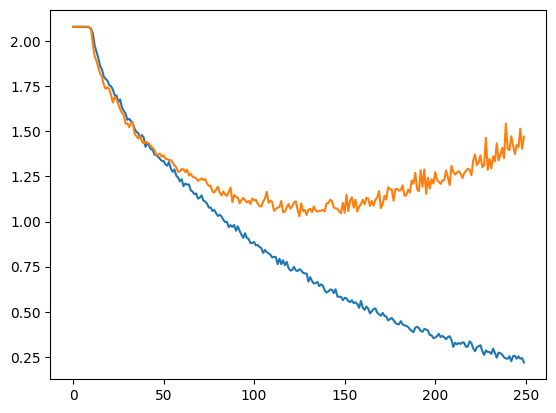

In [64]:
import matplotlib.pyplot as plt

plt.plot(h.train_loss)
plt.plot(h.val_loss )
plt.savefig("result/"+model_name+"/loss_plot.png")

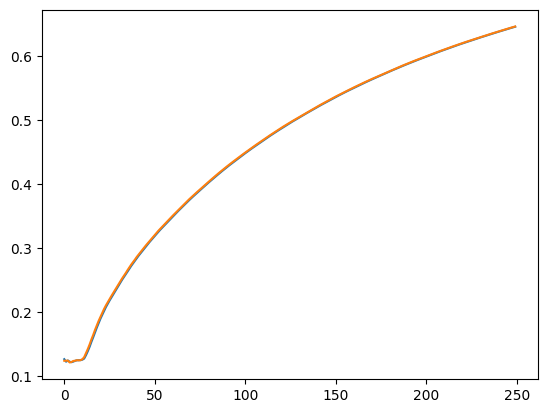

In [65]:
plt.plot(h.train_acc)
plt.plot( h.val_acc)
plt.savefig("result/"+model_name+"/accuracy_plot.png")

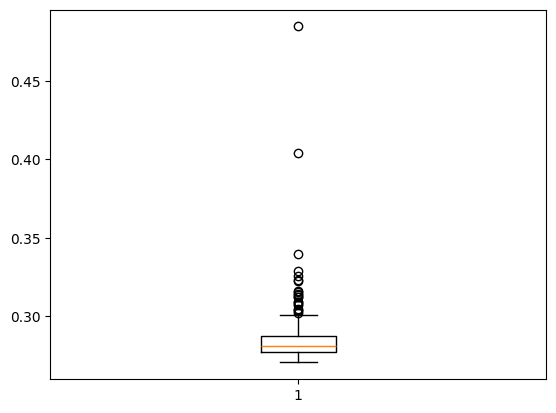

In [66]:
plt.boxplot(h.times)
plt.savefig("result/"+model_name+"/time_spent_per_epoch.png")

In [67]:
import pandas as pd
pd.DataFrame(h.__dict__).to_csv("result/"+model_name+"/data.csv")